# ML Classification of online shoppers' intentions

In [1]:
%matplotlib inline

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import datetime
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

import imblearn
from imblearn.over_sampling import SMOTE


from collections import Counter
import string, re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import MinMaxScaler
import pickle




from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE

#### Abstract

With this task we will try to solve a binary classification problem - to predict if a shopper will make a purchase or not. The dataset is highly imbalanced - we will approach the problem by using SMOTE to resample the 2 classes. We also will use PCA for dimensionality reduction after transforming all categorical features to numeric - we have reduced the attributes to 57 from 75, which explain 95% of the variance of the data. We still expect that the model will overfit on train data.

Our baseline classification model will be Naive Bayes. We will compare it's performance with Random forest classifier and Ada Boost.

Metrics that we used is F1 score macro - will still reflect true model performance even when the classes are skewed.

Best model is: Ada Boost with Logistic Regression, converges fast and has a good testing score of 0.71. Optimized Random Forest has a higher testing score, but converges much slower, thus is costly.

## 1. Task Summry

### 1.1 Task Description

Please examine the dataset with Google Analytics data of online shop visitors provided on the following link: https://archive.ics.uci.edu/ml/machine-learning-databases/00468/
The target variable “Revenue” labels the visitors of the online shop as clients that have made a purchase (true) and clients that haven’t completed a purchase (false).
Please tune, test and evaluate with the appropriate metrics at least two machine learning classification algorithms for the purpose of creating a predictive model that generalizes well on new clients predicting whether a client is going to make a purchase from a website or not based on the explanatory variables provided in the dataset. Please comment on the results and select the one best performing algorithm for the task at hand. Comment on the possible business applications of the final predictive model selected.





### 1.2 Data description


The data set is a set of 18 features: 10 numerical and 8 categorical. This dataset has 12330 entries, split into 10,422 entries where the shoppers did not purchase and 1908 entries where the shoppers did purchase. Each entry is based on unique users in a 1-year period to avoid any trends specific to a specific campaign.


Column Descriptions:
- Administrative: This is the number of pages of this type (administrative) that the user visited.

- Administrative_Duration: This is the amount of time spent in this category of pages.

- Informational: This is the number of pages of this type (informational) that the user visited.

- Informational_Duration: This is the amount of time spent in this category of pages.

- ProductRelated: This is the number of pages of this type (product related) that the user visited.

- ProductRelated_Duration: This is the amount of time spent in this category of pages.

- BounceRates: The percentage of visitors who enter the website through that page and exit without triggering any additional tasks.

- ExitRates: The percentage of pageviews on the website that end at that specific page.

- PageValues: The average value of the page averaged over the value of the target page and/or the completion of an eCommerce transaction.


- SpecialDay: This value represents the closeness of the browsing date to special days or holidays (eg Mother's Day or Valentine's day) in which the transaction is more likely to be finalized. More information about how this value is calculated below.

- Month: Contains the month the pageview occurred, in string form.

- OperatingSystems: An integer value representing the operating system that the user was on when viewing the page.

- Browser: An integer value representing the browser that the user was using to view the page.

- Region: An integer value representing which region the user is located in.

- TrafficType: An integer value representing what type of traffic the user is categorized into.


- VisitorType: A string representing whether a visitor is New Visitor, Returning Visitor, or Other.

- Weekend: A boolean representing whether the session is on a weekend.

- Revenue: A boolean representing whether or not the user completed the purchase.

## 2. Exploratory Data Analysis

In [8]:
path = r"C:\Users\PC\Desktop\Data Science\online_shoppers_intention.csv"

In [9]:
online_shop = pd.read_csv(path, sep=',')

In [10]:
### 12330 records and 18 attributes

online_shop.shape

(12330, 18)

In [11]:
### Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue are categorical variables
### that have to be converted to numeric

online_shop.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [12]:
### count of each attribute is 12330, thus no missing data

online_shop.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


In [13]:
### double check for missing values
online_shop.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [15]:
### Convert Months to date time for visualization purposes - time series trendline
online_shop.Month.loc[online_shop.Month == 'June'] = 'Jun'

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
online_shop.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'Jun', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [18]:
online_shop['date_time'] = pd.to_datetime(online_shop.Month.astype(str) ,format='%b').dt.month

## 2.1 Data Vizualization

**The target value is Revenue and the whole purpose of collecting the data is to predict if a customer will or will not make a purchase. Based on the categorical variables we can make some assumptions/hypotheses on what factors might influence customers' behavior in online shop, such as:**
* is there a peak in purchases during a specific month
* does a Region has an impact on sales
* is there a difference between weekend and weekday purchasing behaviors
* is there an outstanding type of shopper that purchases more often than the others

### Target Label - Revenue 

In [19]:
rev = online_shop.groupby('Revenue').agg({'Revenue': ['count']}).reset_index()
rev.columns = rev.columns.droplevel(0)
rev.rename(columns = {'':'Purchase'},inplace = True)

In [20]:
rev

,Purchase,count
0,False,10422
1,True,1908


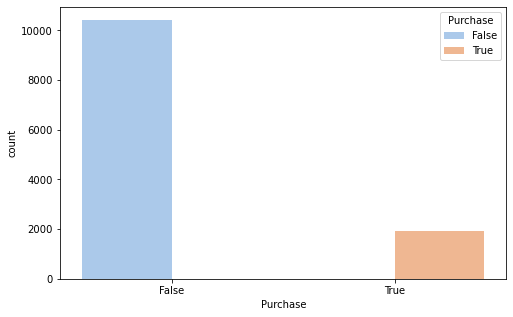

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(data=rev, x="Purchase", y="count", hue="Purchase",palette = 'pastel')
plt.show()

We have a highly imbalanced dataset - True values are only 15% of all records. The assumption is that the model will 'learn' to recognize False records better than True values, thus it will get a pretty high accuracy for predicting the majority class and fail to capture the minority class. Most machine learning algorithms work best when the number of samples in each class is about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

There are different approaches to solving the problem with minority class:
- SMOTE
- ROSSE
- Cohen's kappa coefficient
- Area under the curve
- Confusion matrix 

For this task, we will use SMOTE.

We will use F1 macro score to evaluate the models, again because we have a highly imbalanced dataset.



### Revenue trend in time

In [25]:
revenue_per_month_false = online_shop[online_shop.Revenue == False].groupby('date_time').agg({'Revenue': ['count']}).reset_index()
revenue_per_month_false.columns = revenue_per_month_false.columns.droplevel(1)
revenue_per_month_false.rename(columns = {'Revenue':'No_purchase'},inplace = True)

In [26]:
revenue_per_month_false

,date_time,No_purchase
0,2,181
1,3,1715
2,5,2999
3,6,259
4,7,366
5,8,357
6,9,362
7,10,434
8,11,2238
9,12,1511


In [27]:
revenue_per_month_true = online_shop[online_shop.Revenue == True].groupby('date_time').agg({'Revenue': ['count']}).reset_index()
revenue_per_month_true.columns = revenue_per_month_true.columns.droplevel(1)
revenue_per_month_true.rename(columns = {'Revenue':'Purchase'},inplace = True)

In [28]:
revenue_per_month_true

,date_time,Purchase
0,2,3
1,3,192
2,5,365
3,6,29
4,7,66
5,8,76
6,9,86
7,10,115
8,11,760
9,12,216


In [29]:
revenue_per_month_total = revenue_per_month_true.merge(revenue_per_month_false, on = 'date_time', how = 'left')

In [30]:
revenue_per_month_total['total_visitors'] = revenue_per_month_total['Purchase'] + revenue_per_month_total['No_purchase']

In [31]:
revenue_per_month_total['%'] = ((revenue_per_month_total['Purchase'] / revenue_per_month_total['total_visitors']) *100).round(decimals = 2)

In [32]:
revenue_per_month_total

,date_time,Purchase,No_purchase,total_visitors,%
0,2,3,181,184,1.63
1,3,192,1715,1907,10.07
2,5,365,2999,3364,10.85
3,6,29,259,288,10.07
4,7,66,366,432,15.28
5,8,76,357,433,17.55
6,9,86,362,448,19.20
7,10,115,434,549,20.95
8,11,760,2238,2998,25.35
9,12,216,1511,1727,12.51


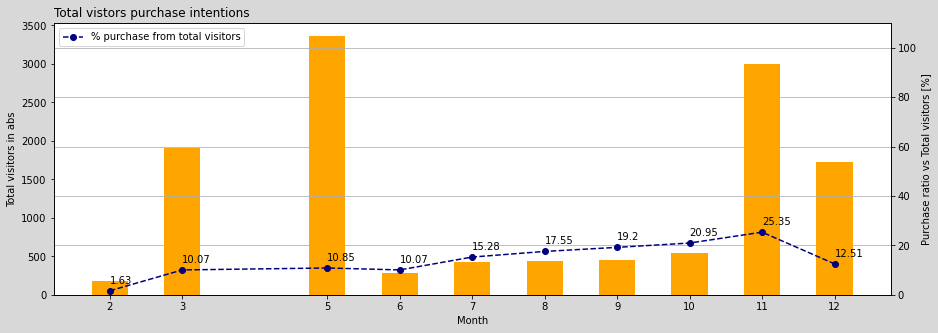

In [33]:
fig,ax1 = plt.subplots(figsize=(15,5))
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.3)

ax2 = ax1.twinx() # secondary y-axis
ax1.bar(revenue_per_month_total['date_time'], revenue_per_month_total['total_visitors'], width=0.5,color = 'orange', align='center')


ax2.plot (revenue_per_month_total['date_time'], revenue_per_month_total['%'],'--',linewidth=1.5, marker = 'o', color = 'navy',label = "% purchase from total visitors")

plt.xticks(revenue_per_month_total['date_time'])
ax2.set_ylabel(f'Purchase ratio vs Total visitors [%]')
ax1.set_ylabel(f'Total visitors in abs')
ax1.set_xlabel("Month")
plt.title(f"Total vistors purchase intentions", loc = 'left')
ax2.legend(loc = "upper left")
ax2.set_ylim(0,110)
offset = 3
#offset_2 = 4
for i,v in zip(revenue_per_month_total['date_time'],revenue_per_month_total['%']):
    plt.annotate(v, (i,v+offset))

plt.grid(True)

plt.show()

In [34]:
#purchase_weekend = online_shop[(online_shop.Revenue ==True) &(online_shop.Weekend ==True) ]

There is a peak in the sales in November, which is expected - most sales are happening around Black Friday in preparation for Christmas gifts.

### Purchase weekends vs weekdays and based on types of customers

In [35]:
no_purchase=online_shop[(online_shop.Revenue ==False)]
purchase = online_shop[(online_shop.Revenue ==True)]

In [36]:
no_purchase_weekend = no_purchase.groupby(['VisitorType', 'Weekend']).agg({'Revenue': ['count']}).reset_index()
no_purchase_weekend.columns = no_purchase_weekend.columns.droplevel(1)

In [37]:
no_purchase_weekend[no_purchase_weekend.Weekend == False]

,VisitorType,Weekend,Revenue
0,New_Visitor,False,898
2,Other,False,63
4,Returning_Visitor,False,7092


In [38]:

purchase_weekend = purchase.groupby(['VisitorType', 'Weekend']).agg({'Revenue': ['count']}).reset_index()
purchase_weekend.columns = purchase_weekend.columns.droplevel(1)

In [40]:
def plot_comparison(df1, df2, title,label_1, label_2,ticks,n):
    plt.figure(figsize=(15,5))
    fig.patch.set_facecolor('grey')
    fig.patch.set_alpha(0.3)
    width = 0.3 
    ind = np.arange(n)
    plt.bar(ind, df1 , width, label=label_1)
    plt.bar(ind + width, df2, width, label=label_2)

    plt.xlabel('Stats')
    plt.ylabel('Count stats' )
    plt.title(title)

    plt.xticks(ind + width / 2, ticks)
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()

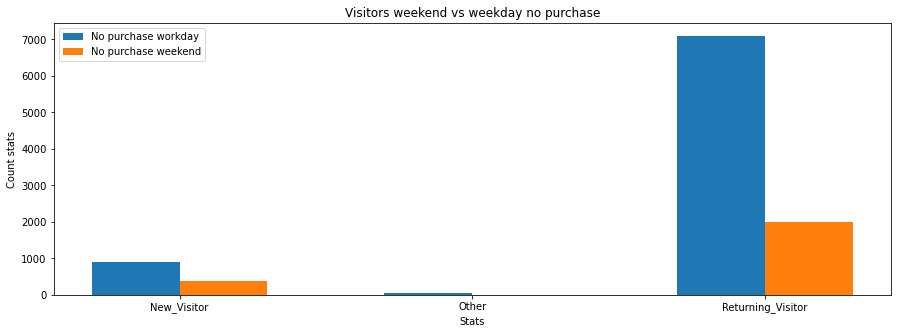

In [41]:
plot_comparison(
no_purchase_weekend[no_purchase_weekend.Weekend == False]['Revenue'],

no_purchase_weekend[no_purchase_weekend.Weekend == True]['Revenue'],

'Visitors weekend vs weekday no purchase',

'No purchase workday',
    
'No purchase weekend',


('New_Visitor','Other','Returning_Visitor'),

3

)





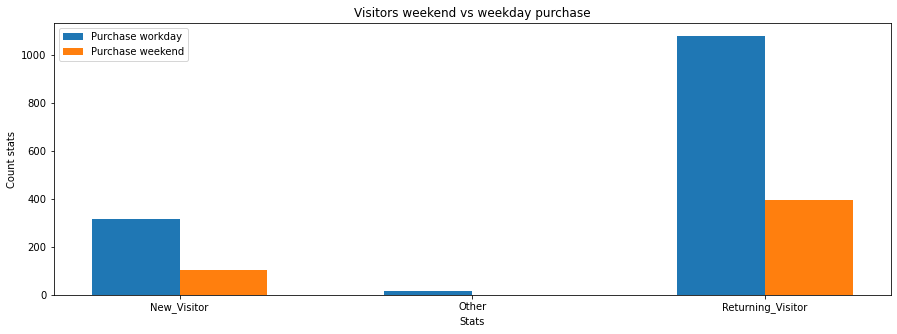

In [42]:
plot_comparison(
purchase_weekend[purchase_weekend.Weekend == False]['Revenue'],

purchase_weekend[purchase_weekend.Weekend == True]['Revenue'],

'Visitors weekend vs weekday purchase',

'Purchase workday',
    
'Purchase weekend',


('New_Visitor','Other','Returning_Visitor'),

3

)

### Purchase operating system

In [46]:
no_purchase_op_sys = no_purchase.groupby(['OperatingSystems']).agg({'Revenue': ['count']}).reset_index()
no_purchase_op_sys.columns = no_purchase_op_sys.columns.droplevel(1)

In [47]:
purchase_op_sys = purchase.groupby(['OperatingSystems']).agg({'Revenue': ['count']}).reset_index()
purchase_op_sys.columns = purchase_op_sys.columns.droplevel(1)

In [48]:
no_purchase_op_sys['OperatingSystems']

0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
Name: OperatingSystems, dtype: int64

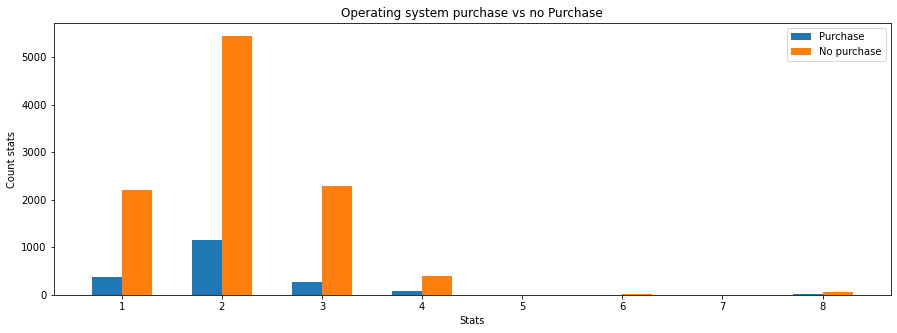

In [49]:
plot_comparison(
purchase_op_sys['Revenue'],

no_purchase_op_sys['Revenue'],

'Operating system purchase vs no Purchase',

'Purchase',
    
'No purchase',


(1,2,3,4,5,6,7,8),

8

)

### Region Purchase

In [50]:
purchase_region = purchase.groupby(['Region']).agg({'Revenue': ['count']}).reset_index()
purchase_region.columns = purchase_region.columns.droplevel(1)

In [51]:
no_purchase_region = no_purchase.groupby(['Region']).agg({'Revenue': ['count']}).reset_index()
no_purchase_region.columns = no_purchase_region.columns.droplevel(1)

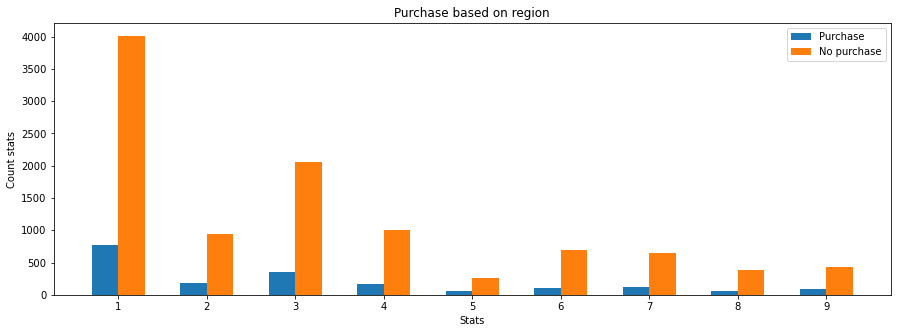

In [52]:
plot_comparison(
purchase_region['Revenue'],

no_purchase_region['Revenue'],

'Purchase based on region',

'Purchase',
    
'No purchase',


(1,2,3,4,5,6,7,8,9),

9

)

### 3. Prepare data for modelling
#### Convert categorical data to numerical

In [54]:
online_shop_model = online_shop

In [55]:
online_shop_model.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
date_time                    int64
dtype: object

In [56]:

le = LabelEncoder()

online_shop_model['Weekend_numeric'] = le.fit_transform(online_shop_model['Weekend'])
online_shop_model['Revenue_numeric'] = le.fit_transform(online_shop_model['Revenue'])

In [57]:
online_shop_model = online_shop_model.drop(columns = ['date_time','Weekend', 'Revenue'])

In [61]:
online_shop_model = pd.get_dummies(online_shop_model, columns = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType'])

In [148]:
online_shop_model.shape

(12330, 75)

### PCA

### Dimensionality Reduction with PCA

We will use PCA to reduce the dimensionality of the vectorized lyrics ( we will not work with  the whole vocabulary). We want to reduce the dataset in order to get 95% of the variance.

In [63]:
### Month, VisitorType, Weekend and Target Value Revenue has to be converted to numeric data

online_shop_features =online_shop_model.drop(columns=['Revenue_numeric'],axis=1)
online_shop_target=online_shop_model['Revenue_numeric']

In [67]:
### We have to scale the data


ss=StandardScaler()
scaled_features=ss.fit_transform(online_shop_features)

In [68]:
pca = PCA()
pca_ = pca.fit_transform(scaled_features)

In [69]:
pca_

array([[-4.65607137e+00, -5.06684091e-01, -2.16430313e+00, ...,
        -3.92022853e-15, -9.36958655e-16,  8.87268789e-18],
       [-1.11834592e+00, -7.62488058e-01,  6.44851458e-01, ...,
        -2.56299204e-15,  2.42086714e-15, -1.40364994e-15],
       [-4.75112122e+00,  5.88172366e-01, -1.06767141e+00, ...,
        -3.27363335e-15, -7.54788866e-15,  2.63083224e-15],
       ...,
       [-1.44951568e+00, -1.22567960e+00,  1.17087136e+00, ...,
         1.27847247e-17, -4.88794954e-17,  8.05536743e-17],
       [ 4.24305140e-01, -4.72243453e-01,  7.87281654e-01, ...,
        -1.55408838e-16, -1.04033926e-16,  1.07985440e-16],
       [-1.36842474e-01,  1.02635613e+00, -1.97301214e-01, ...,
         6.75729289e-17, -2.38705361e-16,  8.50617432e-17]])

In [70]:
explained_variance_ratio_sum = np.cumsum(pca.explained_variance_ratio_)

In [71]:
def plot_cum_expl_var(data):
    plt.figure(figsize=(6, 4))
    plt.plot(range(data.shape[1]), explained_variance_ratio_sum)
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.95)[0][0] + 1, color="green", linestyle="--", label = '95% explained variance')
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.90)[0][0] + 1, color="orange", linestyle="--", label = '90% explained variance')
    plt.axvline(np.where(explained_variance_ratio_sum >= 0.80)[0][0] + 1, color="red", linestyle="--",label = '80% explained variance')
    
    
    
    plt.legend()
    plt.title("PCA explained variance vs number of components")
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance [%]')
    plt.show()

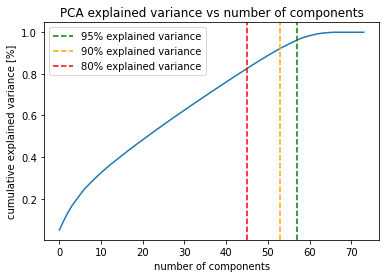

In [72]:
plot_cum_expl_var(pca_)

In [73]:
pca_95 = PCA(n_components = 0.95)
pca_reduced = pca_95.fit_transform(scaled_features)

In [74]:
pca_reduced.shape

(12330, 57)

In [75]:
online_shop_target.unique()

array([0, 1], dtype=int64)

In [76]:
x_features = pca_reduced
y_target = online_shop_target

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=42)

In [92]:
x_train.shape

(9864, 57)

### SMOTE

SMOTE solves the problem with imbalanced data by oversampling the examples in the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line

In [98]:

oversample = SMOTE()
x_train_sm,y_train_sm = oversample.fit_resample(x_train,y_train)


In [99]:
### before resampling
pd.Series(y_train).value_counts()

0    8367
1    1497
Name: Revenue_numeric, dtype: int64

In [100]:
### after resampling
pd.Series(y_train_sm).value_counts()

1    8367
0    8367
Name: Revenue_numeric, dtype: int64

### Cross validation of  the data with K-Fold

To evaluate the performance of the classification algorithm used in this study we will apply k-fold cross validation. Generally, when the amount of data is large, k-fold cross-validation should be employed
to estimate the accuracy of the model, because the accuracy resulting from the training data of the model
is usually too optimistic. For example, when 80% of the data is used for training and 20%
of the data as test set, it is possible that the test set happens to contain data points that are particularly
easy (or hard) to predict. By adding Stratified we ensure that each fold of dataset has the same proportion of observations with a given label.

In [97]:
k_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

### 4.1  Baseline Classifier 
### Naive  Bayes Classifiers
### Gaussian NB

Naive Bayes classifiers are probabilistic classifiers that calculate the probability of each category using Bayes’ theorem, and output the category with the highest probability. It is known for its simplicity, accuracy, and speed.  

Gaussian NB  can work with negative values and we can test it without rescaling the data. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution

In [134]:
params_G_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search_g_nb = GridSearchCV(estimator = GaussianNB(),param_grid = params_G_NB, cv = k_fold, scoring="f1_macro")
grid_search_g_nb.fit(x_train_sm, y_train_sm)
g_nb  = grid_search_g_nb.best_estimator_

print("Gaussian NB best score:", grid_search_g_nb.best_score_)

Gaussian NB best score: 0.5985477226682094


In [135]:
gaussian_g_nb_test = grid_search_g_nb.score(x_test, y_test)

In [136]:
gaussian_g_nb_test

0.4306758517966859

In [137]:
def print_scores(model_eval):
    predictions = model_eval.predict(x_test)
    predictions_probabilities = model_eval.predict_proba(x_test)
    print(classification_report(y_test, predictions))

In [138]:
print_scores(grid_search_g_nb)

              precision    recall  f1-score   support

           0       0.92      0.37      0.53      2055
           1       0.21      0.83      0.33       411

    accuracy                           0.45      2466
   macro avg       0.56      0.60      0.43      2466
weighted avg       0.80      0.45      0.49      2466



In [139]:
def plot_confusion_matrix(model_eval):
    conf_matrix = confusion_matrix(y_test, model_eval.predict(x_test), labels=np.unique(y_test))
    plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix")
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))

    display.plot(ax=plt.gca())
    plt.show()

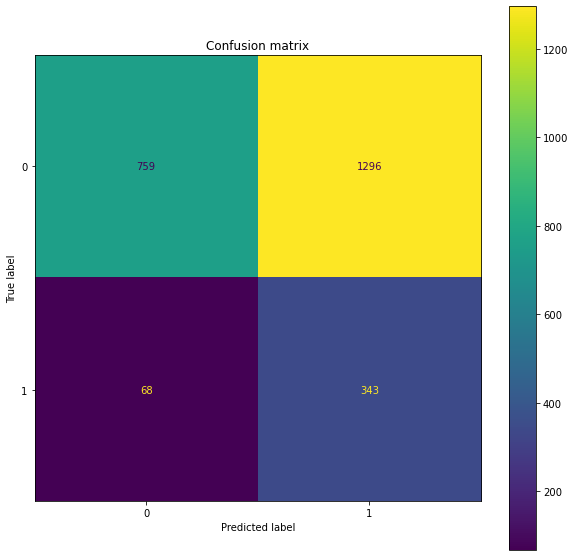

In [142]:
plot_confusion_matrix(grid_search_g_nb)

### 4.2 Random Forest Classifier

In [141]:
params = {'n_estimators':[100, 200, 300], 'max_depth' : [20, 50, 100],'criterion' : ['gini', 'entropy']}
grid_search = GridSearchCV(estimator = RandomForestClassifier(),param_grid = params, cv = k_fold, scoring="f1_macro")
grid_search.fit(x_train_sm, y_train_sm)
forest_classifier  = grid_search.best_estimator_

print("Random forest best score:", grid_search.best_score_)

Random forest best score: 0.9348471853290019


In [143]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 50, 'n_estimators': 200}

In [144]:
forest_classifier_testing_score = grid_search.score(x_test, y_test)

In [145]:
forest_classifier_testing_score

0.7227652454783242

In [146]:
print_scores(grid_search)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2055
           1       0.59      0.48      0.53       411

    accuracy                           0.86      2466
   macro avg       0.74      0.71      0.72      2466
weighted avg       0.85      0.86      0.85      2466



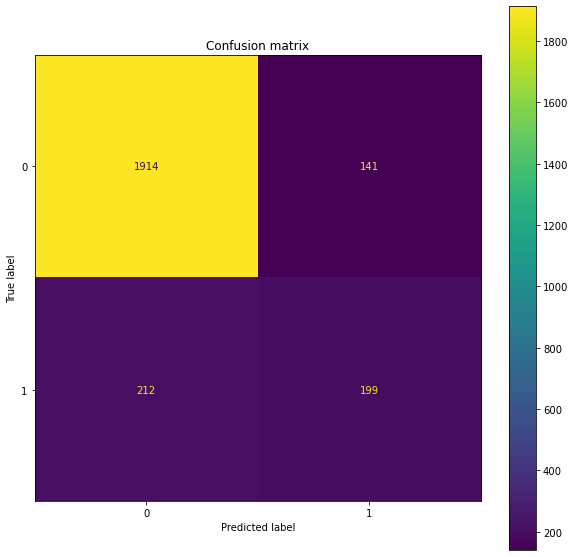

In [147]:
plot_confusion_matrix(grid_search)

### 4.3  Ada Boost Classifier with Logistic Regression

In [128]:

params_ada = {"n_estimators": [100,150], "base_estimator": [LogisticRegression(C = 1e5, solver='liblinear')]}
grid_search_ada = GridSearchCV(estimator = AdaBoostClassifier(),param_grid = params_ada, cv = k_fold, scoring="f1_macro")
grid_search_ada.fit(x_train_sm, y_train_sm)
ada_forest_classifier  = grid_search_ada.best_estimator_

print("Ada Boost with Logistic Regression; best score:", grid_search_ada.best_score_)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` w

Ada Boost with Logistic Regression; best score: 0.7991948918883813


In [129]:
grid_search_ada.best_params_

{'base_estimator': LogisticRegression(C=100000.0, solver='liblinear'),
 'n_estimators': 100}

In [130]:
ada_logistic_testing_score = grid_search_ada.score(x_test, y_test)

In [131]:
ada_logistic_testing_score

0.7067944740670102

In [132]:
print_scores(grid_search_ada)

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2055
           1       0.44      0.70      0.54       411

    accuracy                           0.80      2466
   macro avg       0.69      0.76      0.71      2466
weighted avg       0.85      0.80      0.82      2466



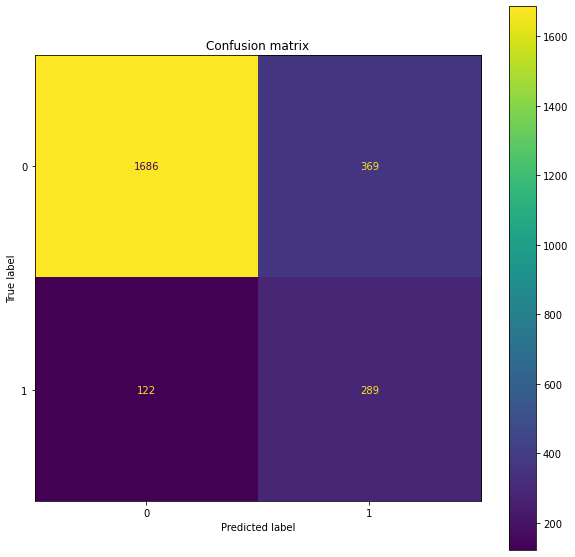

In [133]:
plot_confusion_matrix(grid_search_ada)

### Conclusion

As we expected, even though we have approached the problem with imbalanced data, the model still performs better in predicting the majority class. In reality, most visits to online shops do not end with a purchase. Random forest classifier has a 0.93 f1 score for predicting class 0 or no purchase, ada boost with Logistic Regression has the highest score of 0.54 for predicting class 1 or purchase.

This kind of predictive models can be applied to most online and offline shops or to any other classification, where one of the classes is highly over-represented.

 
